# **importing library**

In [ ]:
#importing library
from torch.utils.data import random_split

import os
import pandas as pd
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
import datetime
import itertools

!pip install optuna


# **connecting to drive for data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **DATASET CLASS**

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

class CustomDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.resize = transforms.Resize((224, 224))  # Resize to 256x256 pixels

        # Shuffle the data
        self.df = self.df.sample(frac=1, random_state=42).reset_index(drop=True)  # Added random_state for reproducibility

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.df.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        image = self.resize(image)  # Resize the image to 256x256 pixels
        label = self.df.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)

        return image, label

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = CustomDataset('/content/drive/MyDrive/3.7/model3.7_label.csv', '/content/drive/MyDrive/3.7/drive data', train_transform)

In [ ]:
train_dataset[522]

(tensor([[[ 1.4612,  1.4954,  1.4954,  ...,  1.5125,  1.4954,  1.5125],
          [ 1.4783,  1.5297,  1.5125,  ...,  1.5125,  1.4954,  1.4954],
          [ 1.5297,  1.5297,  1.5297,  ...,  1.5125,  1.4954,  1.4954],
          ...,
          [ 1.7865,  1.7865,  1.7180,  ...,  1.4954,  1.5125,  1.5125],
          [ 1.7865,  1.7865,  1.7180,  ...,  1.4954,  1.5125,  1.5125],
          [ 1.7865,  1.7523,  1.6838,  ...,  1.4783,  1.5125,  1.5125]],
 
         [[ 0.4678,  0.5028,  0.5028,  ...,  0.1176,  0.1001,  0.1176],
          [ 0.4853,  0.5203,  0.5203,  ...,  0.1001,  0.0826,  0.1001],
          [ 0.5378,  0.5378,  0.5378,  ...,  0.0651,  0.0826,  0.0826],
          ...,
          [ 0.9230,  0.9230,  0.8529,  ...,  0.1001,  0.1176,  0.1176],
          [ 0.9230,  0.9230,  0.8529,  ...,  0.1001,  0.1176,  0.1176],
          [ 0.9230,  0.8880,  0.8179,  ...,  0.0826,  0.1176,  0.1176]],
 
         [[-0.3753, -0.3230, -0.2358,  ..., -1.0550, -1.0724, -1.0550],
          [-0.3404, -0.2532,

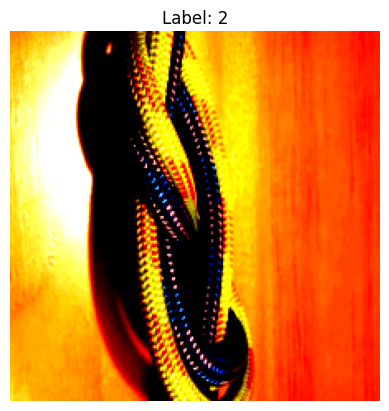

In [ ]:
import matplotlib.pyplot as plt

image, label = train_dataset[522]
plt.imshow(image.permute(1, 2, 0))  # Convert tensor to a NumPy array and display the image
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()


# **DATA SPLIT**

In [ ]:
# Define the proportions
train_size = int(0.7 * len(train_dataset))  # 70% for training
val_size = int(0.15 * len(train_dataset))  # 15% for validation
test_size = len(train_dataset) - train_size - val_size  # 15% for testing

# Split the dataset
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)


# **TRAINING ON MODEL RESNET**:Flemish bend-Hierarchical-Tension-ResNet18

In [ ]:
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

model1 = models.resnet18(pretrained=True)
num_ftrs1 = model1.fc.in_features
model1.fc = nn.Linear(num_ftrs1, 3)

# Assuming you have train_dataloader and val_dataloader already defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 69.8MB/s]


# **Training parameter**

In [ ]:
# Training parameters
num_epochs = 25
lr = 0.00012767273962519026
weight_decay = 0.0001699699637073591
betas = (0.9, 0.9)

Epoch 1/25
Training Loss: 0.6882, Training Accuracy: 68.09%, Validation Accuracy: 83.58%
Epoch 2/25
Training Loss: 0.3271, Training Accuracy: 86.91%, Validation Accuracy: 85.07%
Epoch 3/25
Training Loss: 0.1963, Training Accuracy: 92.98%, Validation Accuracy: 88.56%
Epoch 4/25
Training Loss: 0.1413, Training Accuracy: 94.47%, Validation Accuracy: 93.03%
Epoch 5/25
Training Loss: 0.1445, Training Accuracy: 95.21%, Validation Accuracy: 92.54%
Epoch 6/25
Training Loss: 0.1265, Training Accuracy: 95.96%, Validation Accuracy: 92.54%
Epoch 7/25
Training Loss: 0.1165, Training Accuracy: 95.64%, Validation Accuracy: 91.04%
Epoch 8/25
Training Loss: 0.1265, Training Accuracy: 96.17%, Validation Accuracy: 95.02%
Epoch 9/25
Training Loss: 0.1145, Training Accuracy: 96.49%, Validation Accuracy: 95.52%
Epoch 10/25
Training Loss: 0.1190, Training Accuracy: 96.17%, Validation Accuracy: 89.55%
Epoch 11/25
Training Loss: 0.0770, Training Accuracy: 97.45%, Validation Accuracy: 91.04%
Epoch 12/25
Trainin

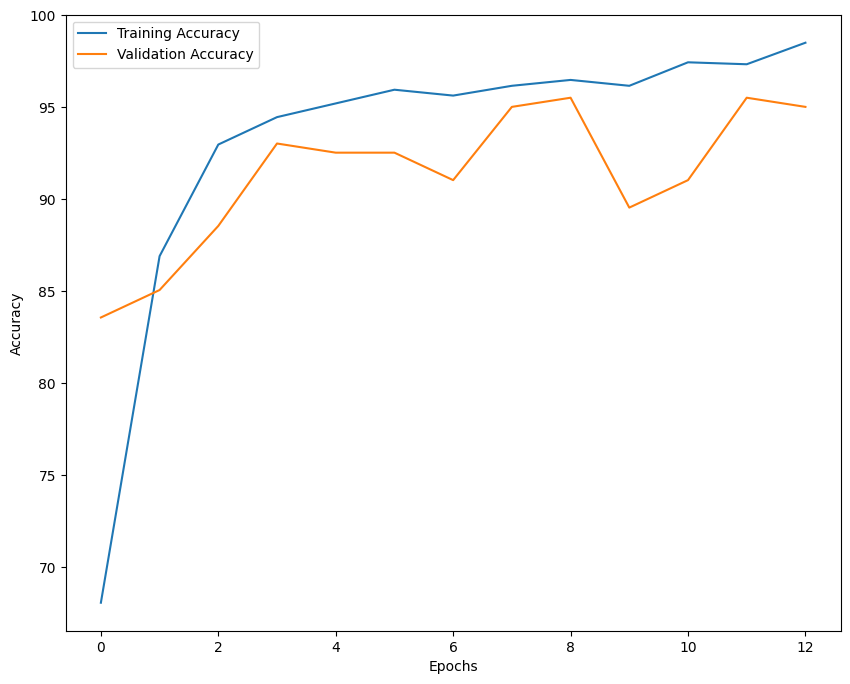

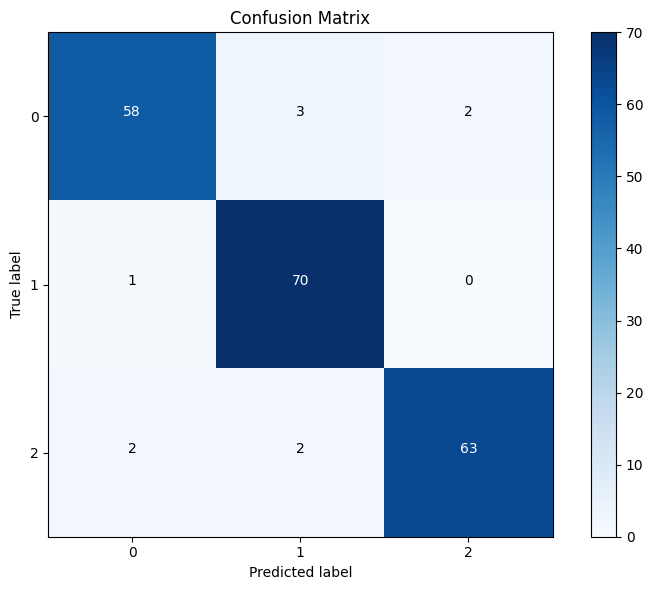

              precision    recall  f1-score   support

           0       0.95      0.92      0.94        63
           1       0.93      0.99      0.96        71
           2       0.97      0.94      0.95        67

    accuracy                           0.95       201
   macro avg       0.95      0.95      0.95       201
weighted avg       0.95      0.95      0.95       201



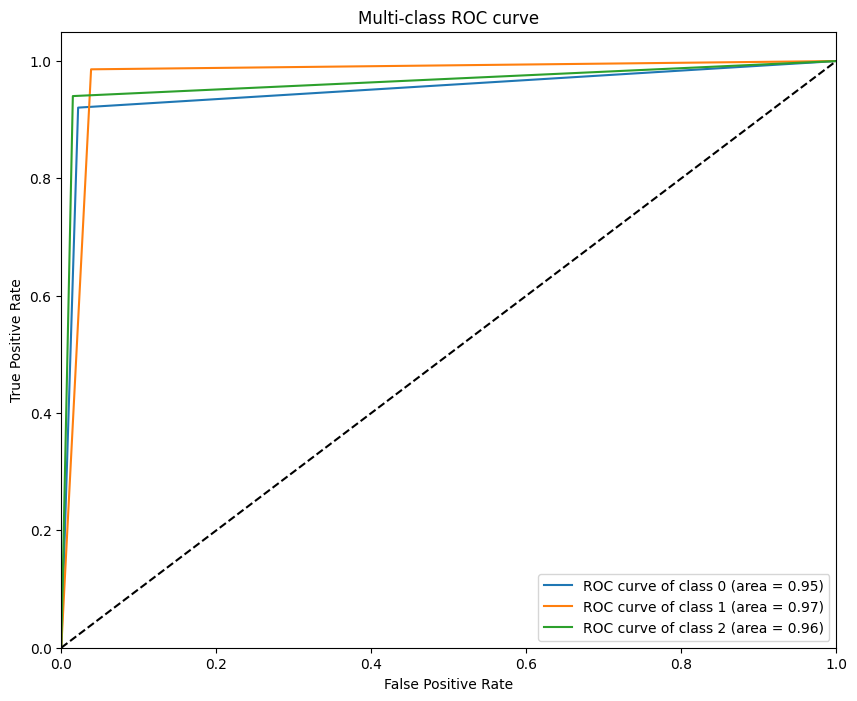

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import itertools

# Assuming the rest of the setup and training code is above...

accuracies = []
train_accuracies = []
train_losses = []  # To store training losses for each epoch
val_losses = []
early_stopping_counter = 0
EARLY_STOPPING_PATIENCE = 5
BEST_VAL_LOSS = float('inf')

model1 = model1.to(device)
optimizer = optim.AdamW(model1.parameters(), lr=lr, weight_decay=weight_decay, betas=betas)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    model1.train()
    train_correct = 0
    train_total = 0
    train_loss = 0.0  # To accumulate training loss for each epoch
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model1(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()  # Accumulate the loss
        _, train_predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (train_predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_losses.append(train_loss / len(train_dataloader))  # Average training loss for the epoch
    train_accuracies.append(train_accuracy)

    model1.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model1(images)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

        accuracy = 100 * correct / total
        accuracies.append(accuracy)
        val_losses.append(val_loss / len(val_dataloader))  # Average validation loss for the epoch

        # Print the status at the end of every epoch
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {accuracy:.2f}%")

        if val_loss < BEST_VAL_LOSS:
            BEST_VAL_LOSS = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= EARLY_STOPPING_PATIENCE:
                print("Early stopping!")
                break

# Plot training and validation accuracy
plt.figure(figsize=(10, 8))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plotting the confusion matrix with values
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(set(all_labels)))
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Displaying the values in the confusion matrix
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# Classification Report
print(classification_report(all_labels, all_predictions))

# Multi-class ROC-AUC Curve
y_true_bin = label_binarize(all_labels, classes=[0, 1, 2])
y_pred_bin = label_binarize(all_predictions, classes=[0, 1, 2])

n_classes = y_true_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC curve')
plt.legend(loc="lower right")
plt.show()


# **Number of parameters trained in this model**

In [ ]:
def count_parameters(model1):
    return sum(p.numel() for p in model1.parameters() if p.requires_grad)

num_params = count_parameters(model1)
print(f"The model1 has {num_params:,} trainable parameters.")


The model1 has 11,178,051 trainable parameters.


# **Evaluation on Test set**

              precision    recall  f1-score   support

     Class 0       0.90      0.88      0.89        65
     Class 1       0.93      0.93      0.93        69
     Class 2       0.96      0.99      0.97        69

    accuracy                           0.93       203
   macro avg       0.93      0.93      0.93       203
weighted avg       0.93      0.93      0.93       203



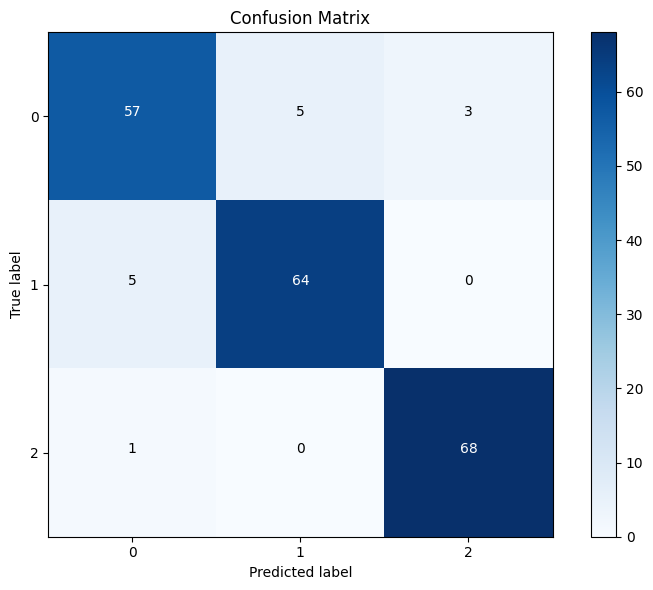

In [ ]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools

# Ensure model1 is in evaluation mode and move it to the appropriate device
model1.eval()
model1 = model1.to(device)

# Lists to store true labels and model predictions
all_labels = []
all_predictions = []

# Evaluate the model on the test set
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model1(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Generate and print the classification report
report = classification_report(all_labels, all_predictions, target_names=["Class 0", "Class 1", "Class 2"])
print(report)

# Plotting the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(set(all_labels)))
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Displaying the values in the confusion matrix
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


# **save model**

In [ ]:
torch.save(model1, '3.7_model1_full.pth')

In [ ]:
# Save only the model's state_dict (recommended for portability)
torch.save(model1.state_dict(), '3.7_model1_state_dict.pth')




# **Model VGG**:Flemish bend-Hierarchical-Tension-VGG16

In [ ]:
model2 = models.vgg16(pretrained=True)
num_ftrs2 = model2.classifier[6].in_features
model2.classifier[6] = nn.Linear(num_ftrs2, 3)

# Assuming you have train_dataloader and val_dataloader already defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 143MB/s]


# **Tuned parameters**

In [ ]:
# Training parameters
num_epochs = 5
lr = 0.00012767273962519026
weight_decay = 0.0001699699637073591
betas = (0.9, 0.9)

Epoch 1/5
Training Loss: 1.0598, Training Accuracy: 43.72%, Validation Accuracy: 68.16%
Epoch 2/5
Training Loss: 0.5888, Training Accuracy: 74.04%, Validation Accuracy: 82.59%
Epoch 3/5
Training Loss: 0.4408, Training Accuracy: 82.23%, Validation Accuracy: 91.04%
Epoch 4/5
Training Loss: 0.3632, Training Accuracy: 87.13%, Validation Accuracy: 87.56%
Epoch 5/5
Training Loss: 0.2607, Training Accuracy: 90.00%, Validation Accuracy: 85.57%


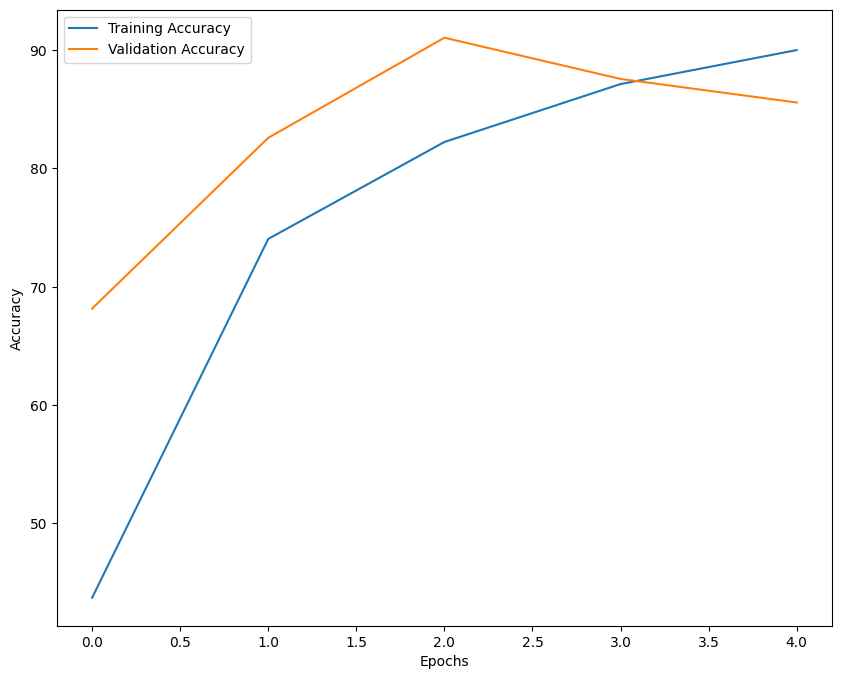

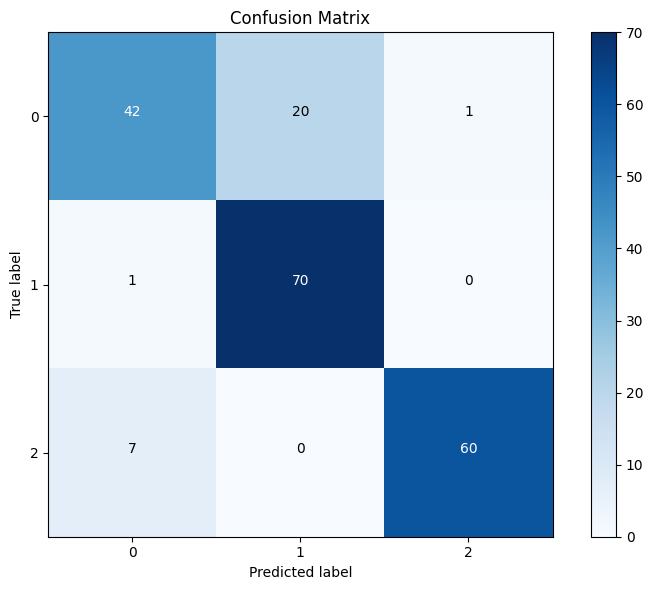

              precision    recall  f1-score   support

           0       0.84      0.67      0.74        63
           1       0.78      0.99      0.87        71
           2       0.98      0.90      0.94        67

    accuracy                           0.86       201
   macro avg       0.87      0.85      0.85       201
weighted avg       0.87      0.86      0.85       201



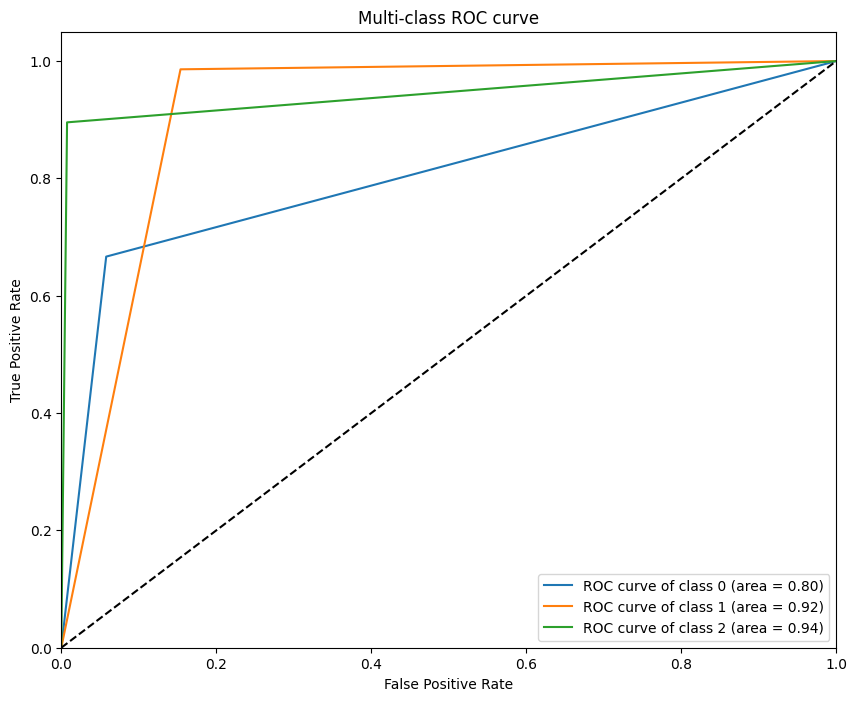

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import itertools
from torch import optim  # Ensure this import is present

# Assuming the rest of the setup and training code is above...

accuracies = []
train_accuracies = []
train_losses = []  # To store training losses for each epoch
val_losses = []
early_stopping_counter = 0
EARLY_STOPPING_PATIENCE = 5
BEST_VAL_LOSS = float('inf')

model2 = model2.to(device)
optimizer = optim.AdamW(model2.parameters(), lr=lr, weight_decay=weight_decay, betas=betas)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    model2.train()
    train_correct = 0
    train_total = 0
    train_loss = 0.0  # To accumulate training loss for each epoch
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model2(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()  # Accumulate the loss
        _, train_predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (train_predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_losses.append(train_loss / len(train_dataloader))  # Average training loss for the epoch
    train_accuracies.append(train_accuracy)

    model2.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model2(images)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

        accuracy = 100 * correct / total
        accuracies.append(accuracy)
        val_losses.append(val_loss / len(val_dataloader))  # Average validation loss for the epoch

        # Print the status at the end of every epoch
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {accuracy:.2f}%")

        if val_loss < BEST_VAL_LOSS:
            BEST_VAL_LOSS = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= EARLY_STOPPING_PATIENCE:
                print("Early stopping!")
                break

# Plot training and validation accuracy
plt.figure(figsize=(10, 8))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plotting the confusion matrix with values
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(set(all_labels)))
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Displaying the values in the confusion matrix
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# Classification Report
print(classification_report(all_labels, all_predictions))

# Multi-class ROC-AUC Curve
y_true_bin = label_binarize(all_labels, classes=[0, 1, 2])
y_pred_bin = label_binarize(all_predictions, classes=[0, 1, 2])

n_classes = y_true_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC curve')
plt.legend(loc="lower right")
plt.show()


# **Number of parameters trained in this model**

In [ ]:
def count_parameters(model2):
    return sum(p.numel() for p in model2.parameters() if p.requires_grad)

num_params = count_parameters(model2)
print(f"The model2 has {num_params:,} trainable parameters.")


The model2 has 134,272,835 trainable parameters.


# **evaluation test set**

              precision    recall  f1-score   support

     Class 0       0.83      0.62      0.71        65
     Class 1       0.78      1.00      0.87        69
     Class 2       0.89      0.86      0.87        69

    accuracy                           0.83       203
   macro avg       0.83      0.82      0.82       203
weighted avg       0.83      0.83      0.82       203



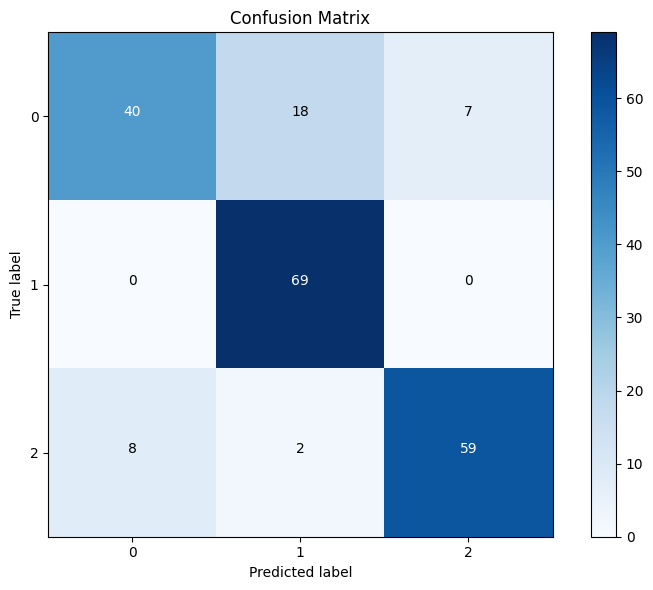

In [ ]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools

# Ensure model2 is in evaluation mode and move it to the appropriate device
model2.eval()
model2 = model2.to(device)

# Lists to store true labels and model predictions
all_labels = []
all_predictions = []

# Evaluate the model on the test set
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Generate and print the classification report
report = classification_report(all_labels, all_predictions, target_names=["Class 0", "Class 1", "Class 2"])
print(report)

# Plotting the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(set(all_labels)))
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Displaying the values in the confusion matrix
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


# **save model**

In [ ]:
# Save only the model's state_dict (recommended for portability)
torch.save(model2.state_dict(), '3.7_model2_state_dict.pth')

torch.save(model2, '3.7_model2_full.pth')


# **model mobilenetv2**:Flemish bend-Hierarchical-Tension-MobileNetV2

In [ ]:
model3 = models.mobilenet_v2(pretrained=True)
num_ftrs6 = model3.classifier[1].in_features
model3.classifier[1] = nn.Linear(num_ftrs6, 3)

# Assuming you have train_dataloader and val_dataloader already defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 75.9MB/s]


# **Tuned parameters**

In [ ]:
# Training parameters
num_epochs = 5
lr = 0.00012767273962519026
weight_decay = 0.0001699699637073591
betas = (0.9, 0.9)

# **Training**

Epoch 1/5
Training Loss: 0.7386, Training Accuracy: 64.47%, Validation Accuracy: 82.09%
Epoch 2/5
Training Loss: 0.2883, Training Accuracy: 89.15%, Validation Accuracy: 93.03%
Epoch 3/5
Training Loss: 0.1639, Training Accuracy: 93.62%, Validation Accuracy: 94.03%
Epoch 4/5
Training Loss: 0.1535, Training Accuracy: 94.26%, Validation Accuracy: 94.03%
Epoch 5/5
Training Loss: 0.1202, Training Accuracy: 95.74%, Validation Accuracy: 94.03%


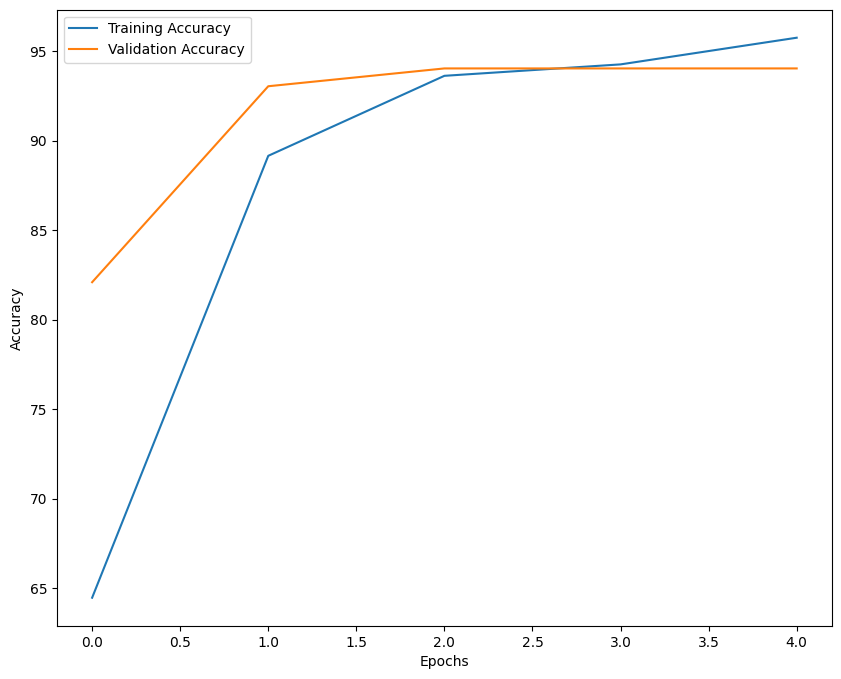

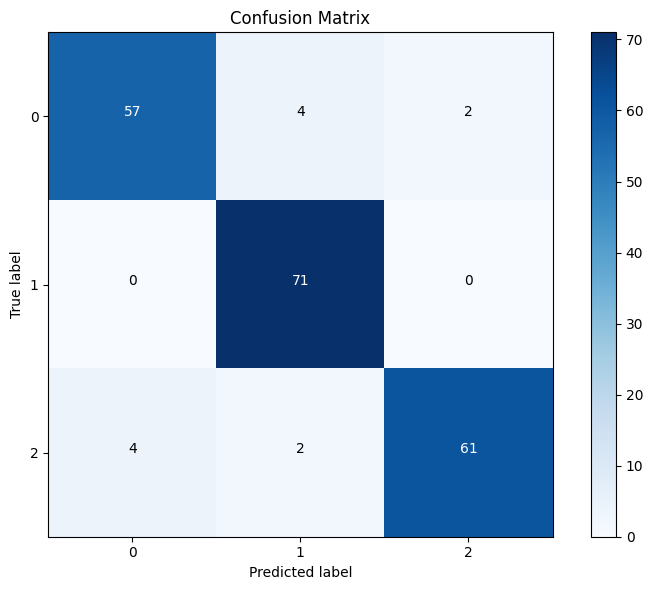

              precision    recall  f1-score   support

           0       0.93      0.90      0.92        63
           1       0.92      1.00      0.96        71
           2       0.97      0.91      0.94        67

    accuracy                           0.94       201
   macro avg       0.94      0.94      0.94       201
weighted avg       0.94      0.94      0.94       201



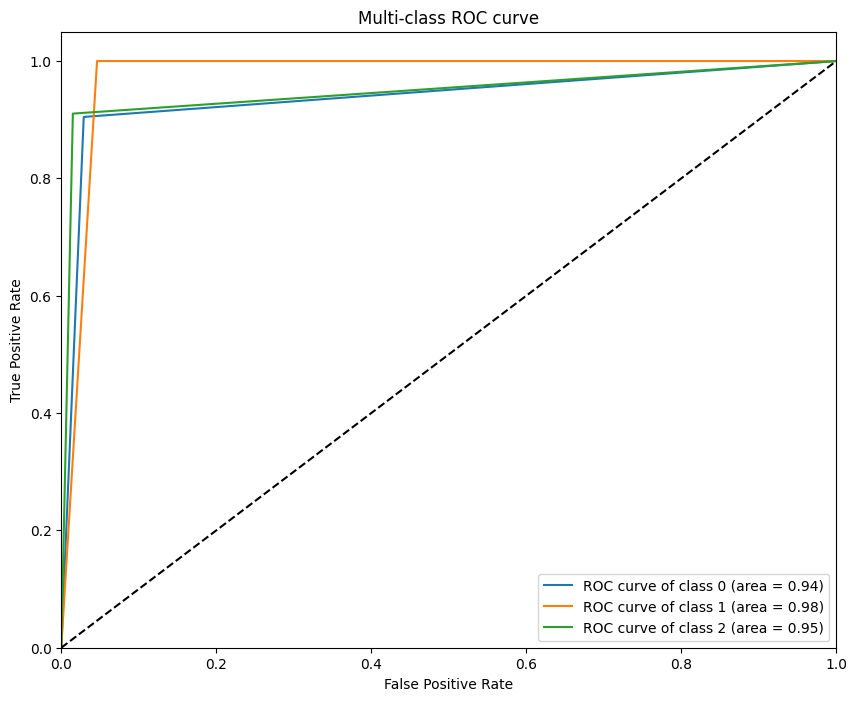

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import itertools
from torch import optim  # Ensure this import is present

# Assuming the rest of the setup and training code is above...

accuracies = []
train_accuracies = []
train_losses = []  # To store training losses for each epoch
val_losses = []
early_stopping_counter = 0
EARLY_STOPPING_PATIENCE = 5
BEST_VAL_LOSS = float('inf')

model3 = model3.to(device)
optimizer = optim.AdamW(model3.parameters(), lr=lr, weight_decay=weight_decay, betas=betas)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    model3.train()
    train_correct = 0
    train_total = 0
    train_loss = 0.0  # To accumulate training loss for each epoch
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model3(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()  # Accumulate the loss
        _, train_predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (train_predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_losses.append(train_loss / len(train_dataloader))  # Average training loss for the epoch
    train_accuracies.append(train_accuracy)

    model3.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model3(images)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

        accuracy = 100 * correct / total
        accuracies.append(accuracy)
        val_losses.append(val_loss / len(val_dataloader))  # Average validation loss for the epoch

        # Print the status at the end of every epoch
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {accuracy:.2f}%")

        if val_loss < BEST_VAL_LOSS:
            BEST_VAL_LOSS = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= EARLY_STOPPING_PATIENCE:
                print("Early stopping!")
                break

# Plot training and validation accuracy
plt.figure(figsize=(10, 8))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plotting the confusion matrix with values
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(set(all_labels)))
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Displaying the values in the confusion matrix
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# Classification Report
print(classification_report(all_labels, all_predictions))

# Multi-class ROC-AUC Curve
y_true_bin = label_binarize(all_labels, classes=[0, 1, 2])
y_pred_bin = label_binarize(all_predictions, classes=[0, 1, 2])

n_classes = y_true_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC curve')
plt.legend(loc="lower right")
plt.show()


# **Number of parameters trained in this model**

In [ ]:
def count_parameters(model3):
    return sum(p.numel() for p in model3.parameters() if p.requires_grad)

num_params = count_parameters(model3)
print(f"The model3 has {num_params:,} trainable parameters.")


# **evaluation on test**

In [ ]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools

# Ensure model3 is in evaluation mode and move it to the appropriate device
model3.eval()
model3 = model3.to(device)

# Lists to store true labels and model predictions
all_labels = []
all_predictions = []

# Evaluate the model on the test set
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model3(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Generate and print the classification report
report = classification_report(all_labels, all_predictions, target_names=["Class 0", "Class 1", "Class 2"])
print(report)

# Plotting the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(set(all_labels)))
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Displaying the values in the confusion matrix
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


# **Save model**

In [ ]:
# Save only the model's state_dict (recommended for portability)
torch.save(model3.state_dict(), '3.7_model3_state_dict.pth')

torch.save(model3, '3.7_model3_full.pth')


#   **Vision Transformer**


In [ ]:
!pip install timm

# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import timm

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the Vision Transformer model
model_vit = timm.create_model('vit_base_patch16_224', pretrained=True)
num_classes = 3
model_vit.head = nn.Linear(model_vit.head.in_features, num_classes)
model_vit = model_vit.to(device)

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_vit.parameters(), lr=1e-4)
num_epochs=10

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.9 MB/s eta 0:00:00


Epoch 1/10
Training Loss: 1.2471, Training Accuracy: 36.70%, Validation Accuracy: 33.33%
Epoch 2/10
Training Loss: 1.1242, Training Accuracy: 35.11%, Validation Accuracy: 40.80%
Epoch 3/10
Training Loss: 1.1040, Training Accuracy: 37.77%, Validation Accuracy: 39.30%
Epoch 4/10
Training Loss: 1.0251, Training Accuracy: 46.91%, Validation Accuracy: 59.20%
Epoch 5/10
Training Loss: 0.8416, Training Accuracy: 60.21%, Validation Accuracy: 66.17%
Epoch 6/10
Training Loss: 0.6404, Training Accuracy: 70.32%, Validation Accuracy: 80.60%
Epoch 7/10
Training Loss: 0.4360, Training Accuracy: 80.85%, Validation Accuracy: 78.11%
Epoch 8/10
Training Loss: 0.2786, Training Accuracy: 89.26%, Validation Accuracy: 83.58%
Epoch 9/10
Training Loss: 0.2322, Training Accuracy: 91.28%, Validation Accuracy: 84.08%
Epoch 10/10
Training Loss: 0.2022, Training Accuracy: 92.87%, Validation Accuracy: 85.07%


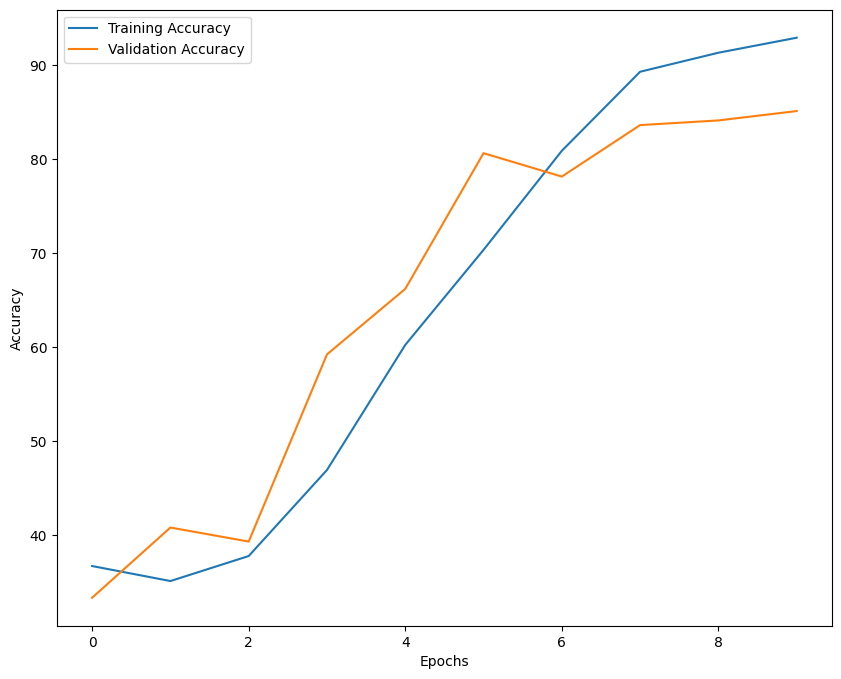

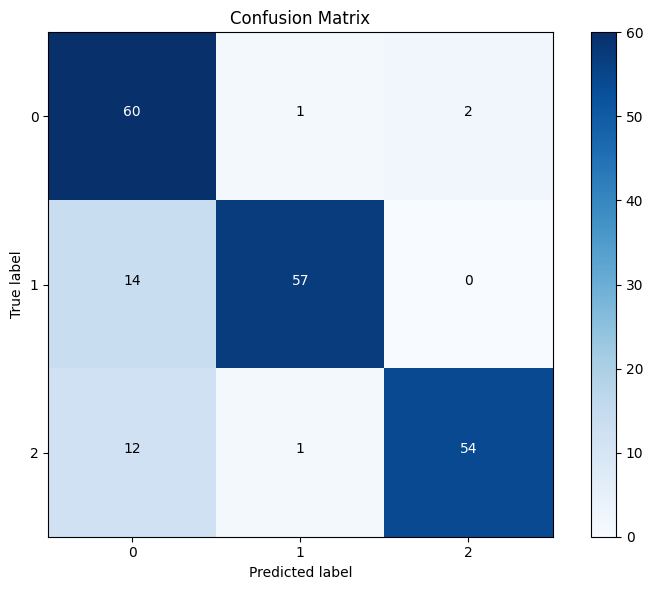

              precision    recall  f1-score   support

           0       0.70      0.95      0.81        63
           1       0.97      0.80      0.88        71
           2       0.96      0.81      0.88        67

    accuracy                           0.85       201
   macro avg       0.88      0.85      0.85       201
weighted avg       0.88      0.85      0.85       201



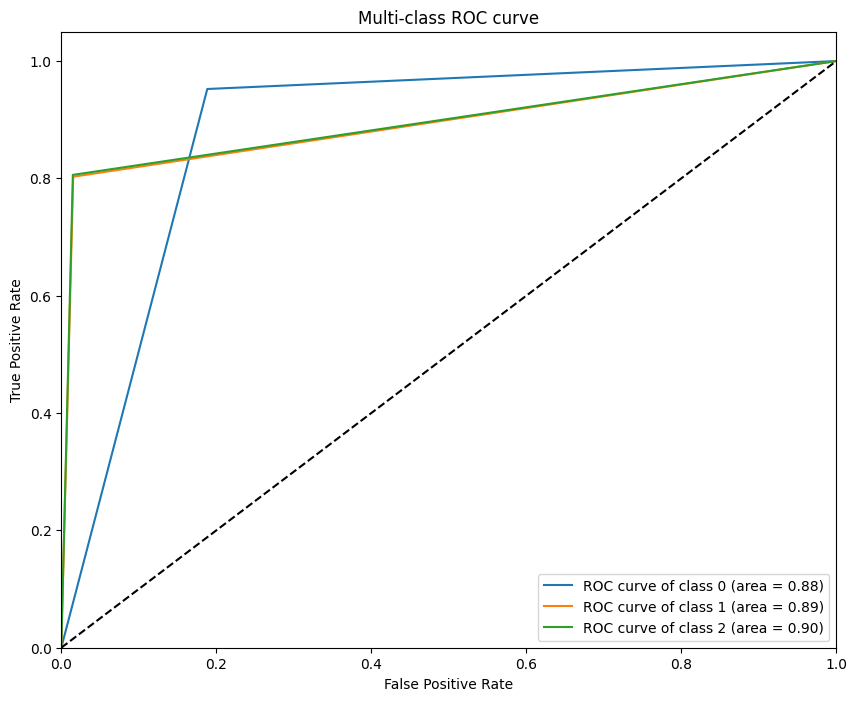

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import itertools



accuracies = []
train_accuracies = []
train_losses = []  # To store training losses for each epoch
val_losses = []
early_stopping_counter = 0
EARLY_STOPPING_PATIENCE = 5
BEST_VAL_LOSS = float('inf')

model_vit = model_vit.to(device)
optimizer = optim.AdamW(model_vit.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    model_vit.train()
    train_correct = 0
    train_total = 0
    train_loss = 0.0  # To accumulate training loss for each epoch
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_vit(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()  # Accumulate the loss
        _, train_predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (train_predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    train_losses.append(train_loss / len(train_dataloader))  # Average training loss for the epoch
    train_accuracies.append(train_accuracy)

    model_vit.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_vit(images)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

        accuracy = 100 * correct / total
        accuracies.append(accuracy)
        val_losses.append(val_loss / len(val_dataloader))  # Average validation loss for the epoch

        # Print the status at the end of every epoch
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {accuracy:.2f}%")

        if val_loss < BEST_VAL_LOSS:
            BEST_VAL_LOSS = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= EARLY_STOPPING_PATIENCE:
                print("Early stopping!")
                break

# Plot training and validation accuracy
plt.figure(figsize=(10, 8))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plotting the confusion matrix with values
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(set(all_labels)))
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Displaying the values in the confusion matrix
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# Classification Report
print(classification_report(all_labels, all_predictions))

# Multi-class ROC-AUC Curve
y_true_bin = label_binarize(all_labels, classes=[0, 1, 2])
y_pred_bin = label_binarize(all_predictions, classes=[0, 1, 2])

n_classes = y_true_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC curve')
plt.legend(loc="lower right")
plt.show()


# **Number of parameters trained in this model**

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Using the function
model_parameters = count_parameters(model_vit)
print(f"The model has {model_parameters:,} trainable parameters.")


The model has 85,800,963 trainable parameters.


# **evaluation on test set**

              precision    recall  f1-score   support

     Class 0       0.66      0.94      0.78        65
     Class 1       0.95      0.80      0.87        69
     Class 2       0.98      0.75      0.85        69

    accuracy                           0.83       203
   macro avg       0.86      0.83      0.83       203
weighted avg       0.87      0.83      0.83       203



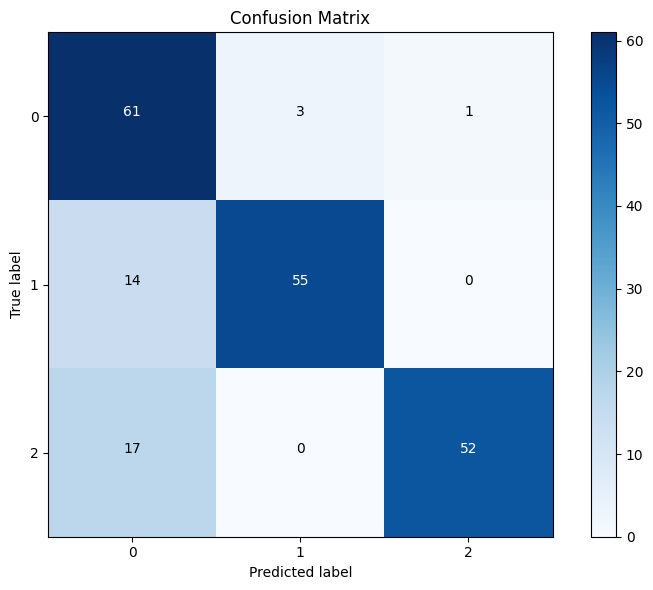

In [ ]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import itertools

# Ensure model_vit is in evaluation mode and move it to the appropriate device
model_vit.eval()
model_vit = model_vit.to(device)

# Lists to store true labels and model predictions
all_labels = []
all_predictions = []

# Evaluate the model on the test set
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_vit(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Generate and print the classification report
report = classification_report(all_labels, all_predictions, target_names=["Class 0", "Class 1", "Class 2"])
print(report)

# Plotting the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(set(all_labels)))
plt.xticks(tick_marks, tick_marks)
plt.yticks(tick_marks, tick_marks)
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Displaying the values in the confusion matrix
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


# **save model**

In [ ]:
# Save the entire model
torch.save(model_vit, '3.7_model_vit.pth')



In [ ]:
# Save only the model's state_dict (recommended for portability)
torch.save(model_vit.state_dict(), '3.7_model_vit_state_dict.pth')
